# Personalisable Hierarchical Models

## The Setup, AKA the Essence of [4_Hierarchical_3-Compartment](4_Hierarchical_3-Compartment)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az
import pickle

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [74]:
# import and visualise data

MylanTDPDays100 = np.genfromtxt('Data/DailyMed_MylanTDP_n36/MylanTDP_n36_100mcg.csv', delimiter=',', skip_header=True)
MylanTDPDays50 = np.genfromtxt('Data/DailyMed_MylanTDP_n36/MylanTDP_n36_50mcg.csv', delimiter=',', skip_header=True)
MylanTDPDays25 = np.genfromtxt('Data/DailyMed_MylanTDP_n36/MylanTDP_n36_25mcg.csv', delimiter=',', skip_header=True)

H2003aN30Estradot100 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_100mcg.csv', delimiter=',', skip_header=True)
H2003aN30Estradot50 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_50mcg.csv', delimiter=',', skip_header=True)
H2003aN30Estradot37_5 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_37.5mcg.csv', delimiter=',', skip_header=True)
H2003aN30Estradot25 = np.genfromtxt('Data/Hossain2003a_Estradot_n30/H2003a_Estradot_n30_25mcg.csv', delimiter=',', skip_header=True)

H2003bN11Estradot100 = np.genfromtxt('Data/Hossain2003b_Estradot_n11/H2003b_Estradot_n11_100mcg.csv', delimiter=',', skip_header=True)
H2003bN11Estradot50 = np.genfromtxt('Data/Hossain2003b_Estradot_n11/H2003b_Estradot_n11_50mcg.csv', delimiter=',', skip_header=True)

# exclude n = 30 study from H2003b due to the initial measurement being higher than the second measurement
#H2003bN30Estradot50 = np.genfromtxt('Data/Hossain2003b_Estradot_n30/H2003b_Estradot_n30_50mcg.csv', delimiter=',', skip_header=True)

# convert Mylan data from days to hrs, Estradot data is already in hrs
# https://stackoverflow.com/questions/10394659/how-to-add-a-calculated-computed-column-in-numpy

MylanTDP100 = np.vstack((MylanTDPDays100[:,0]*24, MylanTDPDays100[:,1])).T
MylanTDP50 = np.vstack((MylanTDPDays50[:,0]*24, MylanTDPDays50[:,1])).T
MylanTDP25 = np.vstack((MylanTDPDays25[:,0]*24, MylanTDPDays25[:,1])).T

In [3]:
def E2DoseTerm(t, d0, k1, k2, k3, es0=0.0, e20=0.0):
    innerFunc1 = np.exp(-k1 * t) / ((k1 - k2) * (k1 - k3))
    innerFunc2 = np.exp(-k2 * t) / ((k1 - k2) * (k2 - k3))
    innerFunc3 = np.exp(-k3 * t) / ((k1 - k3) * (k2 - k3))
    summationDose = d0 * k1 * k2 * (innerFunc1 - innerFunc2 + innerFunc3)
    if es0 > 0.0:
      summationDose += es0 * k2 / (k2 - k3) * (np.exp(-k3 * t) - np.exp(-k2 * t))
    if e20 > 0.0:
      summationDose += e20 * np.exp(-k3 * t)
    return summationDose

def Es(t, d0, k1, k2):
    return d0 * k1 / (k1 - k2) * (np.exp(-k2 * t) - np.exp(-k1 * t))

def E2Patch(t, d0, k1, k2, k3, W):    # W \equiv t_{\rm rem}
    if t < 0:
        return 0.0
    elif 0 <= t < W:
        return E2DoseTerm(t, d0, k1, k2, k3, es0=0.0, e20=0.0)
    elif t >= W:
        Es_at_W = Es(W, d0, k1, k2)
        E2_at_W = E2DoseTerm(W, d0, k1, k2, k3, es0=0.0, e20=0.0)
        return E2DoseTerm(t - W, 0.0, k1, k2, k3, es0=Es_at_W, e20=E2_at_W)

In [4]:
# alternative to E2Patch, scalar version
def E2PatchLoop(t, d0, k1, k2, k3, W):
    E2Out = np.zeros(len(t))
    for i in range(len(t)):
        if t[i] < 0:
            E2Out[i] = 0.0
        elif 0 <= t[i] < W:
            E2Out[i] = E2DoseTerm(t[i], d0, k1, k2, k3, es0=0.0, e20=0.0)
        elif t[i] >= W:
            Es_at_W = Es(W, d0, k1, k2)
            E2_at_W = E2DoseTerm(W, d0, k1, k2, k3, es0=0.0, e20=0.0)
            E2Out[i] = E2DoseTerm(t[i] - W, 0.0, k1, k2, k3, es0=Es_at_W, e20=E2_at_W)
    return E2Out

In [5]:
# alternative to E2Patch, wihtout if-elif statements, tensor version
def E2DoseTermFull(t, d0, k1, k2, k3, es0, e20):
    innerFunc1 = np.exp(-k1 * t) / ((k1 - k2) * (k1 - k3))
    innerFunc2 = np.exp(-k2 * t) / ((k1 - k2) * (k2 - k3))
    innerFunc3 = np.exp(-k3 * t) / ((k1 - k3) * (k2 - k3))
    summationDose = d0 * k1 * k2 * (innerFunc1 - innerFunc2 + innerFunc3)
    summationDose += es0 * k2 / (k2 - k3) * (np.exp(-k3 * t) - np.exp(-k2 * t))
    summationDose += e20 * np.exp(-k3 * t)
    return summationDose

## Visualise the Gamma and Inverse-Gamma Distributions

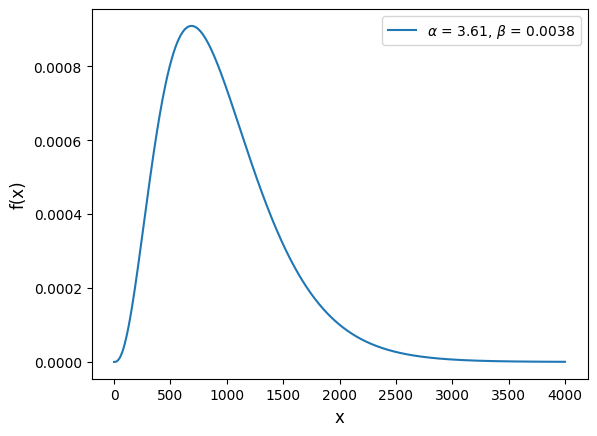

In [7]:
# visualise gamma distribution
# https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.Gamma.html
import scipy.stats as st

x = np.linspace(0, 4000, 1000)
mu = (1500+400)/2
sigma = 500

# the shape parameter, usually set to 1, 2, or 3, https://discord.com/channels/438306949285806082/1201973466845151362/1211192844182884422
# alpha = 0.5 exhibits 1/sqrt close to 0, alpha = 1 exhibits constant close to 0, ...
# ... alpha = 2 exhibits linear close to 0, alpha = 3 exhibits quadratic close to 0, https://discord.com/channels/438306949285806082/1201973466845151362/1211193057639407656
# https://media.discordapp.net/attachments/1201973466845151362/1211194297743970324/image.png?ex=65ed4f97&is=65dada97&hm=4d4967d75964b2dad982c1e8f7534f40b1f2f5545d20ff4d7594b1cd96aea104&=&format=webp&quality=lossless&width=1234&height=943
# the higher the alpha is, and the more strongly you suppress close to zero, the more you necessarily push the bulk of the distribution away from it
alpha = mu**2/sigma**2

beta = mu/sigma**2    # the rate parameter
pdf = st.gamma.pdf(x, a=alpha, scale=1.0/beta)

plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(alpha, beta))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

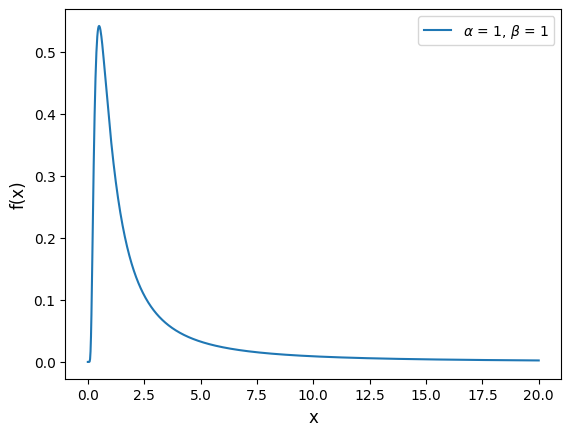

In [70]:
# inverse gamma
# if X ~ Gamma(a, b), then 1/X ~ InverseGamma(a, 1/b)

x = np.linspace(0, 20, 1000)
mu = 1/(100/24)
sigma = 1

# the shape parameter, usually set to 1, 2, or 3, https://discord.com/channels/438306949285806082/1201973466845151362/1211192844182884422
# alpha = 0.5 exhibits 1/sqrt close to 0, alpha = 1 exhibits constant close to 0, ...
# ... alpha = 2 exhibits linear close to 0, alpha = 3 exhibits quadratic close to 0, https://discord.com/channels/438306949285806082/1201973466845151362/1211193057639407656
# https://media.discordapp.net/attachments/1201973466845151362/1211194297743970324/image.png?ex=65ed4f97&is=65dada97&hm=4d4967d75964b2dad982c1e8f7534f40b1f2f5545d20ff4d7594b1cd96aea104&=&format=webp&quality=lossless&width=1234&height=943
# the higher the alpha is, and the more strongly you suppress close to zero, the more you necessarily push the bulk of the distribution away from it
alpha = mu**2/sigma**2

beta = mu/sigma**2    # the rate parameter
pdf = st.invgamma.pdf(x, a=alpha, scale=beta)

plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(alpha, beta))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

## Hierarchical Model of Estradot and Mylan Data

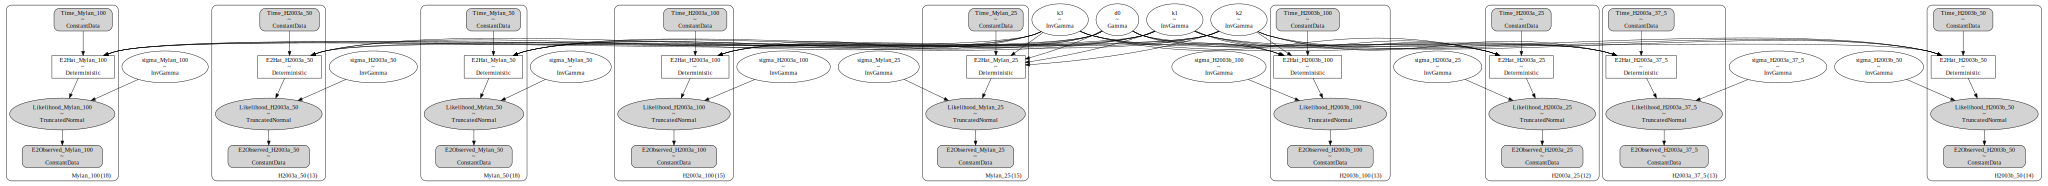

In [99]:
with pm.Model() as PatchHierarchical:

    # Mylan 100 mcg/day
    Mylan100TimeData = pm.ConstantData("Time_Mylan_100", MylanTDP100[:,0], dims="Mylan_100")
    Mylan100Data = pm.ConstantData("E2Observed_Mylan_100", MylanTDP100[:,1], dims="Mylan_100")
    Mylan100sigma = pm.InverseGamma("sigma_Mylan_100", alpha=3, beta=0.5)    # Standard deviation, infer from data

    # Mylan 50 mcg/day
    Mylan50TimeData = pm.ConstantData("Time_Mylan_50", MylanTDP50[:,0], dims="Mylan_50")
    Mylan50Data = pm.ConstantData("E2Observed_Mylan_50", MylanTDP50[:,1], dims="Mylan_50")
    Mylan50sigma = pm.InverseGamma("sigma_Mylan_50", alpha=3, beta=0.5)

    # Mylan 25 mcg/day
    Mylan25TimeData = pm.ConstantData("Time_Mylan_25", MylanTDP25[:,0], dims="Mylan_25")
    Mylan25Data = pm.ConstantData("E2Observed_Mylan_25", MylanTDP25[:,1], dims="Mylan_25")
    Mylan25sigma = pm.InverseGamma("sigma_Mylan_25", alpha=3, beta=0.5)

    # H2003a, 100 mcg/day
    H2003a100TimeData = pm.ConstantData("Time_H2003a_100", H2003aN30Estradot100[:,0], dims="H2003a_100")
    H2003a100Data = pm.ConstantData("E2Observed_H2003a_100", H2003aN30Estradot100[:,1], dims="H2003a_100")
    H2003a100sigma = pm.InverseGamma("sigma_H2003a_100", alpha=3, beta=0.5)

    # H2003a, 50 mcg/day
    H2003a50TimeData = pm.ConstantData("Time_H2003a_50", H2003aN30Estradot50[:,0], dims="H2003a_50")
    H2003a50Data = pm.ConstantData("E2Observed_H2003a_50", H2003aN30Estradot50[:,1], dims="H2003a_50")
    H2003a50sigma = pm.InverseGamma("sigma_H2003a_50", alpha=3, beta=0.5)

    # H2003a, 37_5 mcg/day
    H2003a37_5TimeData = pm.ConstantData("Time_H2003a_37_5", H2003aN30Estradot37_5[:,0], dims="H2003a_37_5")
    H2003a37_5Data = pm.ConstantData("E2Observed_H2003a_37_5", H2003aN30Estradot37_5[:,1], dims="H2003a_37_5")
    H2003a37_5sigma = pm.InverseGamma("sigma_H2003a_37_5", alpha=3, beta=0.5)

    # H2003a, 25 mcg/day
    H2003a25TimeData = pm.ConstantData("Time_H2003a_25", H2003aN30Estradot25[:,0], dims="H2003a_25")
    H2003a25Data = pm.ConstantData("E2Observed_H2003a_25", H2003aN30Estradot25[:,1], dims="H2003a_25")
    H2003a25sigma = pm.InverseGamma("sigma_H2003a_25", alpha=3, beta=0.5)

    # H2003b, 100 mcg/day
    H2003b100TimeData = pm.ConstantData("Time_H2003b_100", H2003bN11Estradot100[:,0], dims="H2003b_100")
    H2003b100Data = pm.ConstantData("E2Observed_H2003b_100", H2003bN11Estradot100[:,1], dims="H2003b_100")
    H2003b100sigma = pm.InverseGamma("sigma_H2003b_100", alpha=3, beta=0.5)

    # H2003b, 50 mcg/day
    H2003b50TimeData = pm.ConstantData("Time_H2003b_50", H2003bN11Estradot50[:,0], dims="H2003b_50")
    H2003b50Data = pm.ConstantData("E2Observed_H2003b_50", H2003bN11Estradot50[:,1], dims="H2003b_50")
    H2003b50sigma = pm.InverseGamma("sigma_H2003b_50", alpha=3, beta=0.5)

    # set patch removal time
    W = 3.5*24

    ### hyperpriors ###
    #d0GammaMu = pm.Gamma("d0_Gamma_mu", mu=(1500+400)/2, sigma=500)
    #d0GammaSigma = pm.Gamma("d0_Gamma_sigma", mu=500, sigma=500)
    # the above is when we don't know about d0 and it is one level too many in the hierarchy, https://discord.com/channels/438306949285806082/1201973466845151362/1211527645263564850

    d0 = pm.Gamma("d0", mu=(1500+400)/2, sigma=500)
    ### end hyperpriors ###

    ### priors on fitting parameters ###
    # you have a exp(-beta*x) in the distribution, so x's that become larger than 1/beta are suppressed exponentially ...
    # ... you want the prior on d0 to be pretty diffuse, so beta should be very small...
    # ... There's always a good ol' uniform prior with a very high cutoff for d0. https://discord.com/channels/438306949285806082/1201973466845151362/1210814524957921280

    # the initial conditions Aeff0 and E20 depend on k1, https://discord.com/channels/438306949285806082/1201973466845151362/1209306363440930927
    # it's the beta of the gamma distribution that you should use to set the average, not the alpha. ...
    # ... Alpha controls the power-law behavior close to 0 and you'll get wonky stuff if you're setting it too small, https://discord.com/channels/438306949285806082/1201973466845151362/1210805371862646855
    k1 = pm.InverseGamma("k1", mu=1/(100/24), sigma=1)    # based on previous fits
    k2 = pm.InverseGamma("k2", mu=1, sigma=1)
    k3 = pm.InverseGamma("k3", mu=1/37, sigma=1)
    ### end priors ###

    # initial conditions after patch removal
    #Es_at_W = Es(W, d0, k1, k2)
    #E2_at_W = E2DoseTermFull(W, d0, k1, k2, k3, 0.0, 0.0)

    # likelihood
    # The likelihood function can be a lognormal but you have to be careful not to feed it 0 values unless you add a (random) positive...
    # ... baseline first, so like xi ~ LogNormal(log(E2(ti) + b), sigma)

    # Mylan dataset
    # switching to .TruncatedNormal, https://discord.com/channels/438306949285806082/1201973466845151362/1211722357878693978
    E2Hat_Mylan_100 = pm.Deterministic("E2Hat_Mylan_100", pm.math.switch(pm.math.lt(Mylan100TimeData, W),
                                                            E2DoseTermFull(Mylan100TimeData, d0, k1, k2, k3, 0.0, 0.0),
                                                            E2DoseTermFull(Mylan100TimeData - W, 0.0, k1, k2, k3,
                                                                           Es(W, d0, k1, k2),
                                                                           E2DoseTermFull(W, d0, k1, k2, k3, 0.0, 0.0))), dims="Mylan_100")
    Likelihood_Mylan_100 = pm.TruncatedNormal("Likelihood_Mylan_100", mu = E2Hat_Mylan_100, observed = Mylan100Data, sigma=Mylan100sigma, lower=0, dims="Mylan_100")

    E2Hat_Mylan_50 = pm.Deterministic("E2Hat_Mylan_50", pm.math.switch(pm.math.lt(Mylan50TimeData, W),
                                                          E2DoseTermFull(Mylan50TimeData, d0/2, k1, k2, k3, 0.0, 0.0),
                                                          E2DoseTermFull(Mylan50TimeData - W, 0.0, k1, k2, k3,
                                                                         Es(W, d0/2, k1, k2),
                                                                         E2DoseTermFull(W, d0/2, k1, k2, k3, 0.0, 0.0))), dims="Mylan_50")
    Likelihood_Mylan_50 = pm.TruncatedNormal("Likelihood_Mylan_50", mu = E2Hat_Mylan_50, observed = Mylan50Data, sigma=Mylan50sigma, lower=0, dims="Mylan_50")

    E2Hat_Mylan_25 = pm.Deterministic("E2Hat_Mylan_25", pm.math.switch(pm.math.lt(Mylan25TimeData, W),
                                                          E2DoseTermFull(Mylan25TimeData, d0/4, k1, k2, k3, 0.0, 0.0),
                                                          E2DoseTermFull(Mylan25TimeData - W, 0.0, k1, k2, k3,
                                                                         Es(W, d0/4, k1, k2),
                                                                         E2DoseTermFull(W, d0/4, k1, k2, k3, 0.0, 0.0))), dims="Mylan_25")
    Likelihood_Mylan_25 = pm.TruncatedNormal("Likelihood_Mylan_25", mu = E2Hat_Mylan_25, observed = Mylan25Data, sigma=Mylan25sigma, lower=0, dims="Mylan_25")

    # H2003a dataset
    E2Hat_H2003a_100 = pm.Deterministic("E2Hat_H2003a_100", pm.math.switch(pm.math.lt(H2003a100TimeData, W),
                                                             E2DoseTermFull(H2003a100TimeData, d0, k1, k2, k3, 0.0, 0.0),
                                                             E2DoseTermFull(H2003a100TimeData - W, 0.0, k1, k2, k3,
                                                                            Es(W, d0, k1, k2),
                                                                            E2DoseTermFull(W, d0, k1, k2, k3, 0.0, 0.0))), dims="H2003a_100")
    Likelihood_H2003a_100 = pm.TruncatedNormal("Likelihood_H2003a_100", mu = E2Hat_H2003a_100, observed = H2003a100Data, sigma=H2003a100sigma, lower=0, dims="H2003a_100")

    E2Hat_H2003a_50 = pm.Deterministic("E2Hat_H2003a_50", pm.math.switch(pm.math.lt(H2003a50TimeData, W),
                                                            E2DoseTermFull(H2003a50TimeData, d0/2, k1, k2, k3, 0.0, 0.0),
                                                            E2DoseTermFull(H2003a50TimeData - W, 0.0, k1, k2, k3,
                                                                           Es(W, d0/2, k1, k2),
                                                                           E2DoseTermFull(W, d0/2, k1, k2, k3, 0.0, 0.0))), dims="H2003a_50")
    Likelihood_H2003a_50 = pm.TruncatedNormal("Likelihood_H2003a_50", mu = E2Hat_H2003a_50, observed = H2003a50Data, sigma=H2003a50sigma, lower=0, dims="H2003a_50")

    E2Hat_H2003a_37_5 = pm.Deterministic("E2Hat_H2003a_37_5", pm.math.switch(pm.math.lt(H2003a37_5TimeData, W),
                                                                E2DoseTermFull(H2003a37_5TimeData, d0/(100/37.5), k1, k2, k3, 0.0, 0.0),
                                                                E2DoseTermFull(H2003a37_5TimeData - W, 0.0, k1, k2, k3,
                                                                               Es(W, d0/(100/37.5), k1, k2),
                                                                               E2DoseTermFull(W, d0/(100/37.5), k1, k2, k3, 0.0, 0.0))), dims="H2003a_37_5")
    Likelihood_H2003a_37_5 = pm.TruncatedNormal("Likelihood_H2003a_37_5", mu = E2Hat_H2003a_37_5, observed = H2003a37_5Data, sigma=H2003a37_5sigma, lower=0, dims="H2003a_37_5")

    E2Hat_H2003a_25 = pm.Deterministic("E2Hat_H2003a_25", pm.math.switch(pm.math.lt(H2003a25TimeData, W),
                                                            E2DoseTermFull(H2003a25TimeData, d0/4, k1, k2, k3, 0.0, 0.0),
                                                            E2DoseTermFull(H2003a25TimeData - W, 0.0, k1, k2, k3,
                                                                           Es(W, d0/4, k1, k2),
                                                                           E2DoseTermFull(W, d0/4, k1, k2, k3, 0.0, 0.0))), dims="H2003a_25")
    Likelihood_H2003a_25 = pm.TruncatedNormal("Likelihood_H2003a_25", mu = E2Hat_H2003a_25, observed = H2003a25Data, sigma=H2003a25sigma, lower=0, dims="H2003a_25")

    # H2003b dataset
    E2Hat_H2003b_100 = pm.Deterministic("E2Hat_H2003b_100", pm.math.switch(pm.math.lt(H2003b100TimeData, W),
                                                             E2DoseTermFull(H2003b100TimeData, d0, k1, k2, k3, 0.0, 0.0),
                                                             E2DoseTermFull(H2003b100TimeData - W, 0.0, k1, k2, k3,
                                                                            Es(W, d0, k1, k2),
                                                                            E2DoseTermFull(W, d0, k1, k2, k3, 0.0, 0.0))), dims="H2003b_100")
    Likelihood_H2003b_100 = pm.TruncatedNormal("Likelihood_H2003b_100", mu = E2Hat_H2003b_100, observed = H2003b100Data, sigma=H2003b100sigma, lower=0, dims="H2003b_100")

    E2Hat_H2003b_50 = pm.Deterministic("E2Hat_H2003b_50", pm.math.switch(pm.math.lt(H2003b50TimeData, W),
                                                            E2DoseTermFull(H2003b50TimeData, d0/2, k1, k2, k3, 0.0, 0.0),
                                                            E2DoseTermFull(H2003b50TimeData - W, 0.0, k1, k2, k3,
                                                                           Es(W, d0/2, k1, k2),
                                                                           E2DoseTermFull(W, d0/2, k1, k2, k3, 0.0, 0.0))), dims="H2003b_50")
    Likelihood_H2003b_50 = pm.TruncatedNormal("Likelihood_H2003b_50", mu = E2Hat_H2003b_50, observed = H2003b50Data, sigma=H2003b50sigma, lower=0, dims="H2003b_50")

# visualize the model
pm.model_to_graphviz(PatchHierarchical)

In [35]:
# CPU-bound sampling
from multiprocessing import cpu_count
ncpu = cpu_count()

# running HMC
with PatchHierarchical:
    SamplePatch = pm.sample(15000, tune=2000, cores=ncpu-1, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (15 chains in 15 jobs)
NUTS: [sigma_Mylan_100, sigma_Mylan_50, sigma_Mylan_25, sigma_H2003a_100, sigma_H2003a_50, sigma_H2003a_37_5, sigma_H2003a_25, sigma_H2003b_100, sigma_H2003b_50, d0, k1, k2, k3]


Sampling 15 chains for 2_000 tune and 15_000 draw iterations (30_000 + 225_000 draws total) took 845 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


In [38]:
# pickle the trace, http://y-okamoto-psy1949.la.coocan.jp/Python/en/PicklePyMC3/
with PatchHierarchical:
    with open("PickledTraces/SamplePatchFull_TruncatedNormal.pkl", "wb") as f:
        pickle.dump(SamplePatch, f)

In [76]:
# load the trace
with PatchHierarchical:
    SamplePatch = pickle.load(open('PickledTraces/SamplePatchFull_TruncatedNormal.pkl', 'rb'))

In [36]:
samplePatchStats = az.summary(SamplePatch, var_names = ["d0", "k1", "k2", "k3"], kind="stats")
samplePatchStats

,mean,sd,hdi_3%,hdi_97%
d0,996.830,155.335,720.965,1291.933
k1,0.015,0.001,0.012,0.017
k2,0.533,0.124,0.322,0.764
k3,0.108,0.014,0.084,0.134


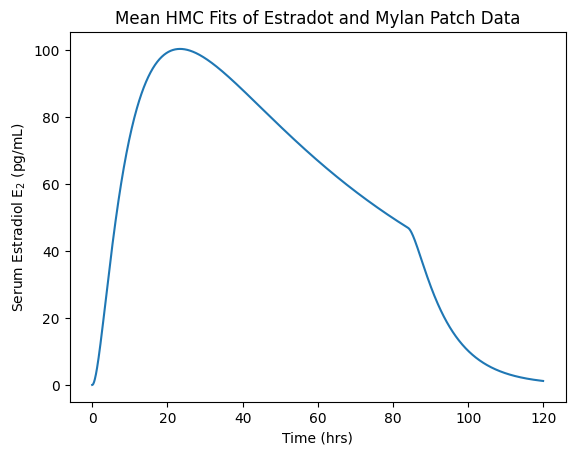

In [43]:
# diagnostic plot
timeSS_ = np.arange(0,5*24,0.1)
E2PatchOut = np.zeros(len(timeSS_))
pMean = np.array([az.summary(SamplePatch, var_names = ["d0"], kind="stats").values[0][0],
                  az.summary(SamplePatch, var_names = ["k1"], kind="stats").values[0][0],
                  az.summary(SamplePatch, var_names = ["k2"], kind="stats").values[0][0],
                  az.summary(SamplePatch, var_names = ["k3"], kind="stats").values[0][0]])
for i in range(len(timeSS_)):
    E2PatchOut[i] = E2Patch(timeSS_[i], *pMean, 3.5*24)
plt.plot(timeSS_, E2PatchOut)
plt.xlabel('Time (hrs)')
plt.ylabel('Serum Estradiol $\\rm E_2$ (pg/mL)')
plt.title("Mean HMC Fits of Estradot and Mylan Patch Data")
plt.show()

# Personalised Prediction

In [52]:
# import personal serum estradiol /measurements
LabData = np.genfromtxt('Data/Patches_Serum_Estradiol_Sharable_12Feb24_Annie.csv', delimiter=',', skip_header=True)
LabDataDosage = LabData[:,0]
LabDataSerumEstradiol = LabData[:,1]
LabDataTimeHrs = LabData[:,2]

In [94]:
LabDataDosage

array([200., 200., 150., 125., 150., 200., 200.])

In [93]:
np.where(LabDataDosage==200)

(array([0, 1, 5, 6]),)

In [89]:
LabDataSerumEstradiol

array([ 386., 1290.,  746.,  290.,  793.,  125., 1341.])

In [87]:
LabDataTimeHrs

array([82.        , 18.        , 21.        , 91.        , 12.91666667,
       96.        , 25.        ])

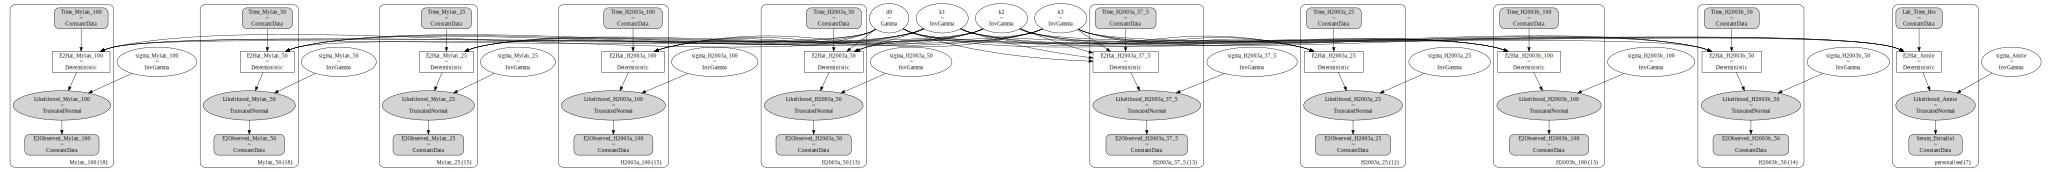

In [100]:
with PatchHierarchical as Personalised:
    PersonalData = pm.ConstantData("Serum_Estradiol", LabDataSerumEstradiol, dims="personalised")
    PersonalDataTime = pm.ConstantData("Lab_Time_Hrs", LabDataDosage, dims="personalised")

    PersonalSigma = pm.InverseGamma("sigma_Annie", alpha=1, beta=1)

    d0_Personal = d0 * (LabDataDosage/100)

    # ignore patch removal
    E2Hat_Annie = pm.Deterministic("E2Hat_Annie", E2DoseTermFull(PersonalDataTime, d0_Personal, k1, k2, k3, 0, 0), dims="personalised")
    Likelihood_Annie = pm.TruncatedNormal("Likelihood_Annie", mu = E2Hat_Annie, observed = PersonalData, sigma=PersonalSigma, lower=0, dims="personalised")

# visualize the model
pm.model_to_graphviz(Personalised)

In [101]:
# ~~reuse previous trace~~ ..., https://discourse.pymc.io/t/saving-intermediate-results-using-mcmc-in-pymc4/9938/10
# ...need https://github.com/pymc-devs/mcbackend to work properly
with Personalised:
    sample_Personalised = pm.sample(15000, tune=2000, cores=ncpu-1, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (15 chains in 15 jobs)
NUTS: [sigma_Mylan_100, sigma_Mylan_50, sigma_Mylan_25, sigma_H2003a_100, sigma_H2003a_50, sigma_H2003a_37_5, sigma_H2003a_25, sigma_H2003b_100, sigma_H2003b_50, d0, k1, k2, k3, sigma_Annie]


Sampling 15 chains for 2_000 tune and 15_000 draw iterations (30_000 + 225_000 draws total) took 941 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


In [102]:
# pickle the trace, http://y-okamoto-psy1949.la.coocan.jp/Python/en/PicklePyMC3/
with Personalised:
    with open("PickledTraces/SamplePatchFull_Personalised.pkl", "wb") as f:
        pickle.dump(sample_Personalised, f)

In [103]:
# load the trace
with Personalised:
    sample_Personalised = pickle.load(open('PickledTraces/SamplePatchFull_Personalised.pkl', 'rb'))

In [104]:
samplePersonalisedStats = az.summary(sample_Personalised, var_names = ["d0", "k1", "k2", "k3"], kind="stats")
samplePersonalisedStats

,mean,sd,hdi_3%,hdi_97%
d0,996.604,154.702,717.461,1286.435
k1,0.015,0.001,0.012,0.017
k2,0.533,0.124,0.322,0.763
k3,0.108,0.014,0.083,0.133


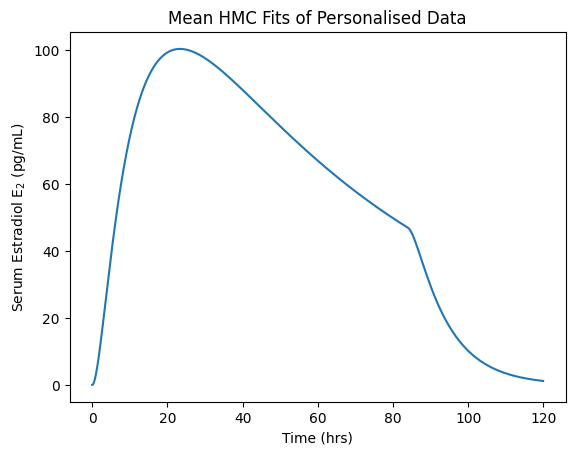

In [105]:
# diagnostic plot
timeSS_ = np.arange(0,5*24,0.1)
E2PatchOut = np.zeros(len(timeSS_))
pMean = np.array([az.summary(sample_Personalised, var_names = ["d0"], kind="stats").values[0][0],
                  az.summary(sample_Personalised, var_names = ["k1"], kind="stats").values[0][0],
                  az.summary(sample_Personalised, var_names = ["k2"], kind="stats").values[0][0],
                  az.summary(sample_Personalised, var_names = ["k3"], kind="stats").values[0][0]])
for i in range(len(timeSS_)):
    E2PatchOut[i] = E2Patch(timeSS_[i], *pMean, 3.5*24)
plt.plot(timeSS_, E2PatchOut)
plt.xlabel('Time (hrs)')
plt.ylabel('Serum Estradiol $\\rm E_2$ (pg/mL)')
plt.title("Mean HMC Fits of Personalised Data")
plt.show()

In [107]:
# extract posteriorp predictive
# https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.htmlRANDOM_SEED = 58
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)
with Personalised:
    pm.sample_posterior_predictive(sample_Personalised, extend_inferencedata=True, random_seed=rng)

sample_Personalised

Sampling: [Likelihood_Annie, Likelihood_H2003a_100, Likelihood_H2003a_25, Likelihood_H2003a_37_5, Likelihood_H2003a_50, Likelihood_H2003b_100, Likelihood_H2003b_50, Likelihood_Mylan_100, Likelihood_Mylan_25, Likelihood_Mylan_50]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [108]:
# pickle the trace, http://y-okamoto-psy1949.la.coocan.jp/Python/en/PicklePyMC3/
with Personalised:
    with open("PickledTraces/SamplePatchFull_Personalised_Posterior_Predictive.pkl", "wb") as f:
        pickle.dump(sample_Personalised, f)

In [111]:
# load the trace
with Personalised:
    sample_Personalised = pickle.load(open('PickledTraces/SamplePatchFull_Personalised_Posterior_Predictive.pkl', 'rb'))

In [112]:
sample_Personalised

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [115]:
### extract predicted serum Estradiol, https://python.arviz.org/en/stable/api/generated/arviz.r2_score.html
E2Hat_Personalised = sample_Personalised.posterior_predictive.stack(sample=("chain", "draw"))["Likelihood_Annie"].values.T

# obtain Maximum A-Posteriori, https://discord.com/channels/438306949285806082/1201973466845151362/1202106780339937310
# https://discourse.pymc.io/t/what-makes-difference-find-map-and-pm-sample/8182
with Personalised:
    MAP_Personalised = pm.find_MAP()
MAP_Personalised

{'sigma_Mylan_100_log__': array(2.39037778),
 'sigma_Mylan_50_log__': array(1.37030438),
 'sigma_Mylan_25_log__': array(1.14520684),
 'sigma_H2003a_100_log__': array(2.16514387),
 'sigma_H2003a_50_log__': array(1.00254336),
 'sigma_H2003a_37_5_log__': array(0.86923062),
 'sigma_H2003a_25_log__': array(0.96993019),
 'sigma_H2003b_100_log__': array(1.68116855),
 'sigma_H2003b_50_log__': array(1.54640274),
 'd0_log__': array(6.89724524),
 'k1_log__': array(-4.22731416),
 'k2_log__': array(-0.69043913),
 'k3_log__': array(-2.23227764),
 'sigma_Annie_log__': array(6.59083103),
 'sigma_Mylan_100': array(10.91761765),
 'sigma_Mylan_50': array(3.93654871),
 'sigma_Mylan_25': array(3.14309142),
 'sigma_H2003a_100': array(8.71585575),
 'sigma_H2003a_50': array(2.7252042),
 'sigma_H2003a_37_5': array(2.38507513),
 'sigma_H2003a_25': array(2.63776031),
 'sigma_H2003b_100': array(5.37182956),
 'sigma_H2003b_50': array(4.69455225),
 'd0': array(989.54499548),
 'k1': array(0.01459153),
 'k2': array(0

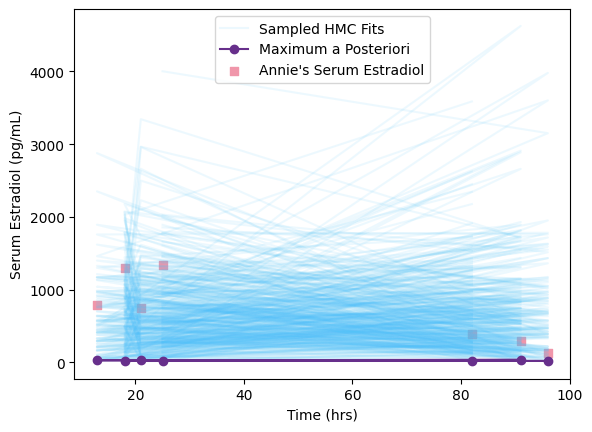

In [116]:
inds = np.random.randint(len(E2Hat_Personalised), size=100)

for ind in inds:
    plt.plot(LabDataTimeHrs, E2Hat_Personalised[ind], alpha=0.1, color='#4EC2F8')
plt.plot(LabDataTimeHrs, E2Hat_Personalised[50000], alpha=0.1, color='#4EC2F8', label='Sampled HMC Fits')
plt.plot(LabDataTimeHrs, MAP_Personalised['E2Hat_Annie'], label='Maximum a Posteriori', color='#672F8B', marker='o')
plt.scatter(LabDataTimeHrs, LabDataSerumEstradiol, color='#F096AA', marker='s', label="Annie's Serum Estradiol")
plt.xlabel('Time (hrs)')
plt.ylabel('Serum Estradiol (pg/mL)')
plt.legend()
plt.show()